# Описание проекта

Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

Наш план по подготовке будет состоять из следующих шагов:

- Откроем файлы и изучим их.
- Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery`. Найдём *MAE* между нашими расчётами и значением признака. Краткий вывод.
- Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
- Предобработка данных

Для начала посмотрим на наши данные.

- gold_recovery_train.csv — обучающая выборка;
- gold_recovery_test.csv — тестовая выборка;
- gold_recovery_full.csv — исходные данные.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

pd.set_option('mode.chained_assignment', None)

df = pd.read_csv('/datasets/gold_recovery_full.csv')
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')

In [2]:
df.shape ,\
df_train.shape ,\
df_test.shape

((22716, 87), (16860, 87), (5856, 53))

Видно, что при разделении не были утеряны данные. Также мы видим, что кол-во признаков в тестовой выборке меньше, чем в обучающей и исходной. 

Это связано с тем, что некоторые параметры недоступны и замеряются / рассчитываются позже. 
    

Посмотрим, каких признаков у нас нет в тестовой сборке

In [3]:
diff = []

for ft in df.columns:
    if ft not in list(df_test.columns):
        diff.append(ft)
new_diff = []
for ft in diff:
    new_diff.append(ft.split('.'))

train_params = pd.DataFrame(columns = ['Этап', 'Тип параметра', 'Название параметра'])    
i = 0
for params in new_diff:
    train_params.loc[i] = params
    i+=1
train_params

,Этап,Тип параметра,Название параметра
0,final,output,concentrate_ag
1,final,output,concentrate_pb
2,final,output,concentrate_sol
3,final,output,concentrate_au
4,final,output,recovery
5,final,output,tail_ag
6,final,output,tail_pb
7,final,output,tail_sol
8,final,output,tail_au
9,primary_cleaner,output,concentrate_ag


У нас имеется список с отсутствующими данными. Большинство из этих признаков относятся к типу параметра `output`, то есть к параметр продукта. В них указаным следующие параметры:

- Отвальные хвосты (`tail_*`)
- Концетраты на разных этапах (`concectrate_*`)
- Эффективность обогащения для этапов `rougher` и `final`. Эти величины и являются целевыми и их отсутствие в тестовой выборке оправдано. 
- `calculation` - расчётные характеристики. 

Проверим, что эффективность обогащения рассчитана правильно. Проверку будем производить на обучающей выборке для признака `rougher.output.recovery`

Формула для расчёта:

$$
Recovery = \frac{C * (F-T)}{F*(C-T)} * 100
$$

где:

- *C* — доля золота в концентрате после флотации/очистки; (`rougher.output.concentrate_au`)
- *F* — доля золота в сырье/концентрате до флотации/очистки; (`rougher.input.feed_au`)
- *T* — доля золота в отвальных хвостах после флотации/очистки. (`rougher.output.tail_au`)


In [4]:
c = df_train['rougher.output.concentrate_au']
f = df_train['rougher.input.feed_au']
t = df_train['rougher.output.tail_au']


df_train['rougher.output.recovery_calc'] = (c * (f-t)/(f * (c-t))) * 100 
df_train[['rougher.output.recovery_calc','rougher.output.recovery']] 

,rougher.output.recovery_calc,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
16855,89.574376,89.574376
16856,87.724007,87.724007
16857,88.890579,88.890579
16858,89.858126,89.858126


В нашей тестовой таблице теперь имеется столбец с рассчётными значениями эффективности. Проверим, имеется ли отрицательная эффективность.

In [5]:
calc = df_train['rougher.output.recovery_calc']
source = df_train['rougher.output.recovery']

(calc < 0).sum(), \
(source < 0).sum(), 

(165, 0)

Действительно. Имеются такие данные. Так как пользы такая обработка не приносит, то заменим значения на нули. 

In [6]:
calc.where(calc > 0, 0, inplace = True)

Теперь мы можем посчитать ошибку рассчётных данных и предоставленных. Единственный момент, который можем нам помешать, это наличие пропусков в *Recovery*. Провреим оба датафрейма на наличие пропусков.

In [7]:
import numpy as np

source.isna().sum() ,\
calc.isna().sum() ,\
source[np.isinf(source)] ,\
calc[np.isinf(calc)]

(2573,
 0,
 Series([], Name: rougher.output.recovery, dtype: float64),
 4034    inf
 Name: rougher.output.recovery_calc, dtype: float64)

Получилась интересная ситуация. В изначальных данных имеется 2.5 тыс пропусков, а также после расчётов получили одно значение = *inf* (4034 строка). Это возможно, когда при расчёте формулы в делителе имеются нули. Произведём замену бесконечности на нули. 

In [8]:
source.fillna(0, inplace = True)
calc[np.isinf(calc)] = 0

Посчитаем *MAE*.

In [9]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(calc, source)

3.0098401978151137

Мы получили MAE = 3. Это может говорить о погрешности показаний и изначальных результатов. 

#### Предобработка данных


Отбросим данные, которые нам не потребуются для дальнейшей обработки. 
- Дата является идентификатором и не несет пользы для расчётов. 
- Не все признаки имеются в тестовой выборке. В связи с этим восстановим тестовые данные из полного. 

In [10]:
# Сохраним даты как индексы тестовой выборки
test_index = df_test.set_index('date').index

# Возьмем данные из полной выборке по индексам.
df_test_rest = df.set_index('date').loc[test_index]
df_test_rest.head(5)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,7.578381,10.466295,11.990938,40.743891,70.273583,12.688885,3.844413,11.075686,4.537988,210.800909,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,7.813838,10.581152,12.216172,39.604292,68.910432,12.829171,3.918901,11.132824,4.675117,215.392455,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,7.623392,10.424024,12.313710,40.724190,68.143213,12.977846,4.026561,10.990134,4.828907,215.259946,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,8.552457,10.503229,13.074570,39.290997,67.776393,12.451947,3.780702,11.155935,4.969620,215.336236,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,8.078781,10.222788,12.475427,40.254524,61.467078,11.827846,3.632272,11.403663,5.256806,199.099327,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


При анализе изначальной выборки мы увидели, что во многих столбцах имеются пропуски. Заполним их медианными значениями. 

In [11]:
df.fillna(df.median(), inplace = True)
df_test_rest.fillna(df_test_rest.median(), inplace = True)
df_train.fillna(df_train.median(), inplace = True)

# 2. Анализ данных

## Концетрация металлов на этапах

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 

final = df[['final.output.concentrate_ag',
       'final.output.concentrate_pb',
       'final.output.concentrate_au']]
final.columns = ['Ag', 'Pb','Au']
rougher = df[['rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb',
       'rougher.output.concentrate_au']]
rougher.columns = ['Ag', 'Pb','Au']
primary_cleaner = df[['primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_au']]
primary_cleaner.columns = ['Ag', 'Pb','Au']

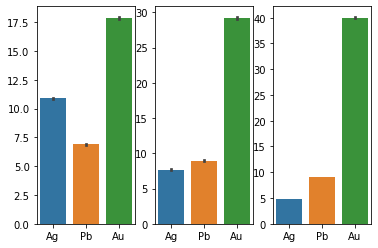

In [13]:
fig, axs = plt.subplots(ncols=3)

sns.barplot(data=rougher, ax=axs[0])
sns.barplot(data=primary_cleaner, ax=axs[1])
sns.barplot(data=final, ax=axs[2])

#### Вывод

По построенному распределнию можно сделать выводы:
- Концетрация золота вырастает более чем в два раза (в процессе обработки)
- Концетрация серебра уменьшается в два раза
- Концетрация свинца не меняется. Это может быть обусловлено диффузией металлов (золота и свинца)

## Сравните распределения размеров гранул сырья на обучающей и тестовой выборках.

За размер гранул у нас отвечает признак *feed_size*. 

In [14]:
test_feed_size = df_test_rest[['primary_cleaner.input.feed_size', 'rougher.input.feed_size']]
train_feed_size = df_train[['date','primary_cleaner.input.feed_size', 'rougher.input.feed_size']].set_index('date')

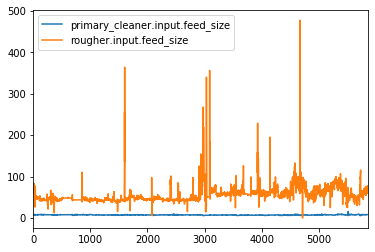

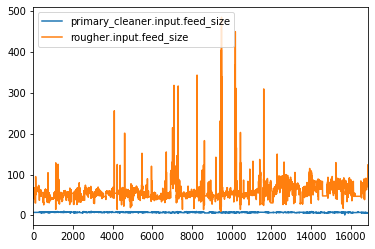

In [15]:
test = pd.DataFrame(test_feed_size)
train = pd.DataFrame(train_feed_size)

test.reset_index().plot()
train.reset_index().plot()

По данному распределению видно, что на этап *rougher* попадают гранулы, сильно отличающиеся по размеру. Наблюдается множество пиков, однако основная масса находится в границах 0-100. Это актуально для двух выборок. 

На этапе первичной очистки гранулы уже нормализованны и разнообразие размером сглажено. 

Мы можем сказать, что размеры гранул в двух выборках схожи и по таким данным можно строить модели. 

## Исследование суммарной концетрации всех веществ на разных стадиях. 

На данном этапе анализа нам необходим выявить аномальные значения в суммарном распределении. В случае, если такие значения имеются - удалить их. 

Под аномальными мы подразумеваем сверхвысокие / сверхнизкие значения.  

In [16]:
def split_stage(df):
    
    elements = ['Ag','Pb','Sol','Au','sum']
    final_conc = df[['final.output.concentrate_ag',
                 'final.output.concentrate_pb',
                 'final.output.concentrate_sol',
                 'final.output.concentrate_au']]
    final_conc['sum'] = final_conc.sum(axis=1)
    final_conc.columns = elements
    

    rough_conc = df[['rougher.output.concentrate_ag',
                 'rougher.output.concentrate_pb',
                 'rougher.output.concentrate_sol',
                 'rougher.output.concentrate_au']]
    
    rough_conc['sum'] = rough_conc.sum(axis=1)
    rough_conc.columns = elements

    prim_clean_conc = df[['primary_cleaner.output.concentrate_ag',
                 'primary_cleaner.output.concentrate_pb',
                 'primary_cleaner.output.concentrate_sol',
                 'primary_cleaner.output.concentrate_au']]
    prim_clean_conc['sum'] = prim_clean_conc.sum(axis=1)
    prim_clean_conc.columns = elements
    
    
    
    return rough_conc, prim_clean_conc, final_conc

In [17]:
train_rough, train_prim, train_final = split_stage(df_train.set_index('date'))
test_rough, test_prim, test_final = split_stage(df_test_rest)

train = [train_rough, train_prim, train_final]
test = [test_rough, test_prim, test_final]

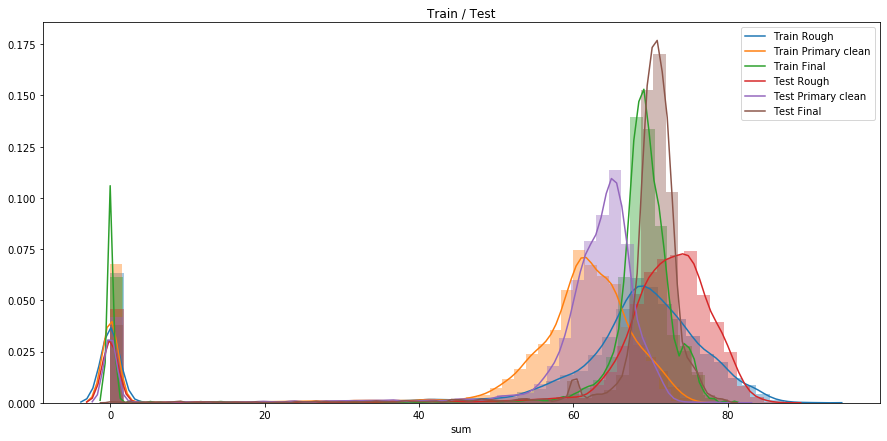

In [18]:
plt.figure(figsize = (15,7))
plt.title('Train / Test')
plt.xlabel('Sum')

sns.distplot(train_rough['sum'], kde_kws={'label':'Train Rough'})
sns.distplot(train_prim['sum'], kde_kws={'label':'Train Primary clean'})
sns.distplot(train_final['sum'], kde_kws={'label':'Train Final'})


sns.distplot(test_rough['sum'], kde_kws={'label':'Test Rough'})
sns.distplot(test_prim['sum'], kde_kws={'label':'Test Primary clean'})
sns.distplot(test_final['sum'], kde_kws={'label':'Test Final'})

Исходя из данного распределения видно, что у нас имеется множество значений равных 0. Такое возможно, если все концетрации веществ равны нулю. Такое возможно только при холостой работе. 

Из тестовой и тренировочной выборки удалим значения равные нулю. 

In [19]:
# Сохраняем уникальные значения индекса (даты) для train и test. Учитываются только те строки, где суммарная концетрация = 0. 
train_0_conc = train_rough[train_rough['sum']==0].index.append(train_prim[train_prim['sum']==0].index).append(train_final[train_final['sum']==0].index).unique()
test_0_conc = test_rough[test_rough['sum']==0].index.append(test_prim[test_prim['sum']==0].index).append(test_final[test_final['sum']==0].index).unique()

In [20]:
df_test_upd = df_test_rest.drop(test_0_conc)
df_train_upd = df_train.set_index('date').drop(train_0_conc, errors = 'ignore')

In [21]:
df_test_upd.shape,\
df_train_upd.shape

((5278, 86), (15111, 87))

## Вывод

В процессе анализа данных было выяснено:

- Концентрация золота из этапа в этап увеличивается. Концентрация серебра уменьшается, однако свинец остаётся на уровне. Может быть связано с диффузией металлов
- На этапе флотации встречаются гранулы различных вариантов и присутствует сильный разброс, однако после первичной обработки размер гранул стабилизируется. Это актуально как для обучающей, так и для тестовой выборки.
- При анализе распределения концентраций на этапах было установлено, что имеется множество значений с концентрацией равной 0, что возможно при условии,  что концентрация всех элементов равна нулю. Такие записи могут привести к ошибкам в данных и значения были удалены.

# 3. Модель

- Напишите функцию для вычисления итоговой *sMAPE*.

- Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

Для расчёта итоговой метрики используем две функции.

In [22]:
from sklearn.metrics import make_scorer

# Calc sMAPE
    
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

# 1/len(A) * np.sum((np.abs(A-F))/(np.abs(A) + np.abs(F))/2) * 100

smape_scorer = make_scorer(smape, greater_is_better = False)

#Calc final sMAPE
def fin_smape(smapeRough, smapeFinal):
    return 0.25 * smapeRough + 0.75 * smapeFinal

Произведём разделение наших выборок и подготовку перед обучением моделей. 


In [23]:
X_train = df_train_upd.drop(['final.output.recovery',
                       'rougher.output.recovery',
                       'rougher.output.recovery_calc'],
                      axis = 1).reset_index(drop = True)
X_test = df_test_upd.drop(['final.output.recovery',
                       'rougher.output.recovery'],
                      axis = 1).reset_index(drop = True)
# Train y
y_1_train = df_train_upd['rougher.output.recovery'].reset_index(drop = True)
y_2_train = df_train_upd['final.output.recovery'].reset_index(drop = True)

# Test y
y_1_test = df_test_upd['rougher.output.recovery'].reset_index(drop = True)
y_2_test = df_test_upd['final.output.recovery'].reset_index(drop = True)

Для упрощения подсчёта итоговой метрики создадим функцию, которая будет возвращать предсказания по кросс-валидации для двух этапов. 

In [24]:
from sklearn.model_selection import cross_val_predict

def cross_val_smape(model):
    
    rougher = cross_val_predict (model, X_train, y_1_train, cv = 3)
    final = cross_val_predict (model, X_train, y_2_train, cv = 3)
       
    return rougher, final

In [25]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()


cv = cross_val_smape(lr)

In [26]:
smape(y_1_train, cv[0])
smape(y_2_train, cv[1])


fin_smape(smape(y_1_train, cv[0]),smape(y_2_train, cv[1]))

13.311054570929576

### LinearRegression

На кросс валидации у нас получился итоговый sMAPE = 2.78, а на тестовых данных = 1.37. Это может говорить об переобучении модели. Проверим работу RandomForestRegressor. 

### RandomForestRegressor

In [27]:
from sklearn.ensemble import RandomForestRegressor

rnd = RandomForestRegressor(random_state = 42, n_estimators = 100, max_depth = 4)

cvR = cross_val_smape(rnd)

In [28]:
fin_smape(smape(y_1_train, cvR[0]),smape(y_2_train, cvR[1]))

12.897029030952364

Модель случайного леса на кросс-валидации получила значение итогового sMAPE = 12.89, что лучше чем модель линейной регрессии. Проверим данную модель на тестовых данных. 

In [29]:
model = RandomForestRegressor(random_state = 42, 
                             n_estimators = 100,
                             max_depth = 4)

model.fit(X_train,y_1_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [30]:
# Для первого этапа
rougher = model.predict(X_test)

# Для финального этапа
final = model.fit(X_train,y_2_train).predict(X_test)

In [31]:
rougher_smape = smape(y_1_test, rougher)
final_smape = smape(y_2_test, final)

fin_smape(rougher_smape, final_smape)

6.4112403037306045

На тестовых данных мы смогли получить итоговый sMAPE = 6.4. 

# Выводы

При выполнении данного проекта были сделаны следующие пункты:
- Проверена формула эффективного обогащения
    - *Показания эффеткивности на тестовой и обучающей выборке имеют небольшую погрешность.*
- Проанализированы признаки, недоступные в тестовой выборке
    - *Недостающие признаки были восстановлены по полной выборке*
- Проведена предобработка данных

*Анализ данных*:
- Исследовано изменение концетрации элементов
    - Была найдена прогрессия в концетрации золота из этапа в этап. 
- Проанализированы распределения гранул сырья на выборках
    - Концетрации на тестовой и обучающей выборке примерно равны. 
- Исследована суммарная концетрация всех веществ на разных стадиях.
    - Были выявлены нулевые значения концетрации, что может сказать о некорректном процессе обработки или получении данных. Аномальные величины удалены

*Построение модели*
- Была построена модель для вычисления *final sMAPE*
- Для обучения были использованы две модели - линейная регрессия и ```RandomForestRegression```. При проверке на кросс-валидации модель леса выдала лучшее качество.